In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('data/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
top10 = df.breed.value_counts()[:10]
df_top10 = df[df.breed.isin(top10.index.values)]
df_top10

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed
...,...,...
10195,ff54d45962b3123bb67052e8e29a60e7,basenji
10200,ff7d9c08091acc3b18b869951feeb013,maltese_dog
10204,ffa0055ec324829882186bae29491645,maltese_dog
10207,ffa4e1bf959425bad9228b04af40ac76,basenji


# Encoding breeds to discrete integer values for compatibility with loss function

In [4]:
df_top10["breed_coded"] = df_top10.breed.astype('category').cat.codes

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Resizing images to (100, 100, 3), splitting into train/test with ratio 9/1

In [5]:
import os
path_to_imgs = 'data/train'

batch_size = 32
img_height = 100
img_width = 100
dim = (img_width, img_height)


def func(id):
    img = cv2.imread(f'{path_to_imgs}/{id}.jpg', cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(df_top10.id, df_top10.breed_coded, 
                                                              test_size=0.1, random_state=42,
                                                             stratify=df_top10.breed_coded)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [7]:
train_images = np.array([func(id) for id in X_train])
test_images = np.array([func(id) for id in X_test])

# Encoding labels into 1/0 vectors

In [8]:
y_binary_train = keras.utils.to_categorical(train_labels)
y_binary_test = keras.utils.to_categorical(test_labels)

# Loading VGG16 model

In [9]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',  # Load weights pre-trained on VGG16
    include_top=False)

58892288/58889256 [==============================] - 15s 0us/step


# Freezing the model

In [10]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
x = base_model.output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
# and a logistic layer -- with 10 classes
predictions = keras.layers.Dense(10, activation='softmax')(x)

# this is the model we will train
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Model training

In [14]:
EPOCHS = 20
history = model.fit(
    train_images, y_binary_train, epochs=EPOCHS
)

Train on 1026 samples
Epoch 1/20
1026/1026 [==============================] - 43s 42ms/sample - loss: 1.7426 - accuracy: 0.4152
Epoch 2/20
1026/1026 [==============================] - 42s 40ms/sample - loss: 1.3248 - accuracy: 0.5955
Epoch 3/20
1026/1026 [==============================] - 42s 41ms/sample - loss: 1.1033 - accuracy: 0.6715
Epoch 4/20
1026/1026 [==============================] - 43s 42ms/sample - loss: 0.9271 - accuracy: 0.7300
Epoch 5/20
1026/1026 [==============================] - 43s 42ms/sample - loss: 0.8202 - accuracy: 0.7836
Epoch 6/20
1026/1026 [==============================] - 42s 41ms/sample - loss: 0.7295 - accuracy: 0.8012
Epoch 7/20
1026/1026 [==============================] - 40s 39ms/sample - loss: 0.6744 - accuracy: 0.8236
Epoch 8/20
1026/1026 [==============================] - 40s 39ms/sample - loss: 0.6138 - accuracy: 0.8392
Epoch 9/20
1026/1026 [==============================] - 40s 39ms/sample - loss: 0.5772 - accuracy: 0.8548
Epoch 10/20
1026/1026 [=

# Some vizualization

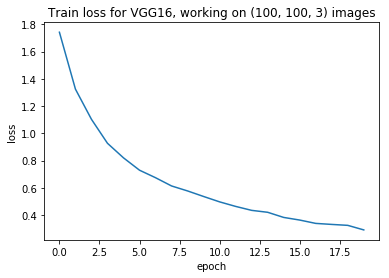

In [21]:
plt.plot(history.history['loss'])
plt.title('Train loss for VGG16, working on (100, 100, 3) images')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("eda&different_graphs/VGG16_100x100forTop10Loss.png", dpi=300)
plt.show()

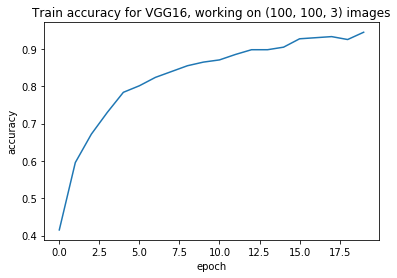

In [22]:
plt.plot(history.history['accuracy'])
plt.title('Train accuracy for VGG16, working on (100, 100, 3) images')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("eda&different_graphs/VGG16_100x100forTop10LAccuracy.png", dpi=300)
plt.show()

# Evaluation on the test images

In [17]:
results = model.evaluate(test_images, y_binary_test, batch_size=batch_size)
print("test loss, test acc:", results)

115/115 [==============================] - 4s 38ms/sample - loss: 1.0711 - accuracy: 0.6261
test loss, test acc: [1.0710984354433806, 0.62608695]


In [18]:
res_df = pd.read_csv('results.csv')
res_df.drop(columns=["Unnamed: 0"], inplace=True)
res_df

,TestAccuracy,TestLoss,ModelDescription
0,190.116042,0.104348,"Fine-tuned AlexNet, Normalized, 150 Epochs, No..."
1,5.512277,0.365217,"Fine-tuned ResNet50 on 50 epochs, with input i..."


In [19]:
res_df = res_df.append(pd.DataFrame({
    "TestAccuracy": [results[0]],
    "TestLoss": [results[1]],
    "ModelDescription": ["Fine-tuned VGG16 on 20 epochs, with input images of shape (100, 100, 3)"]
}))
res_df

,TestAccuracy,TestLoss,ModelDescription
0,190.116042,0.104348,"Fine-tuned AlexNet, Normalized, 150 Epochs, No..."
1,5.512277,0.365217,"Fine-tuned ResNet50 on 50 epochs, with input i..."
0,1.071098,0.626087,"Fine-tuned VGG16 on 20 epochs, with input imag..."


In [20]:
res_df.to_csv('results.csv')